In [3]:
using Plots
using LinearAlgebra
using SparseArrays
using Arpack

In [2]:
module My

Base.@kwdef struct Parameters
    ħc::Float64 = 197
    mc²::Float64 = 938
    
    Z::Int64 = 8 # proton number
    N::Int64 = Z # neutron number
    A::Int64 = Z + N # mass number
    
    # Skyrme Parameters
    t₀::Float64 = -1800
    t₃::Float64 = 12871
    α::Float64 = 1/3
    
    β::Float64 = 0 # deformation parameter of initial density
end

Base.@kwdef struct QuantumNumbers
    Λ::Int64 
    Π::Int64
    q::Int64 = 1
end

Base.@kwdef struct SingleParticleState
    E::Float64
    qnums::QuantumNumbers
    ψ::Array{ComplexF64, 1} # wave function
end

Base.@kwdef struct Densities
    ρ::Array{Float64, 2}
    τ::Array{Float64, 2}
end

end

Main.My

In [3]:
function make_grids(a, N)
    rs = zeros(Float64, N)
    zs = zeros(Float64, N)
    
    for i in 1:N
        rs[i] = a*i - a/2
        zs[i] = a*i - a/2
    end
    
    return rs, zs
end

#=
function trapezoidal_rule(rs, zs, f)
    sum = 0.0
    
    Nr = length(rs)
    Nz = length(zs)
    
    Δr = rs[2] - rs[1]
    Δz = zs[2] - zs[1]
    
    for iz in 1:Nz
        wz = 1.0
        if iz == 1 || iz == Nz
            wz = 1/2
        end
        
        for ir in 1:Nr
            wr = 1.0
            if ir == 1 || ir == Nr
                wr = 1/2
            end
            
            sum += wr*wz*f[ir, iz]
        end
        
    end
    
    sum *= Δr*Δz
    return sum
end
=#

make_grids (generic function with 1 method)

In [4]:
a = 0.1
N = 100
param = My.Parameters()
rs, zs = make_grids(a, N)
zs

100-element Array{Float64,1}:
 0.05
 0.15000000000000002
 0.25000000000000006
 0.35000000000000003
 0.45
 0.55
 0.65
 0.75
 0.85
 0.95
 1.05
 1.1500000000000001
 1.25
 ⋮
 8.85
 8.95
 9.049999999999999
 9.15
 9.25
 9.35
 9.45
 9.55
 9.65
 9.75
 9.85
 9.95

In [5]:
function calc_cij(i,j,a,N,Π)
    cij = 0.0
    if i==1
        cij = ifelse(j==2,1.0,0.0)        
        cij += ifelse(j==1,-Π,0.0)
    elseif i==N
        cij = ifelse(j==N-1,-1.0,0.0)
    else
        cij = ifelse(j==i+1,1.0,0.0)
        cij += ifelse(j==i-1,-1.0,0.0)
    end
    cij = cij/(2a)
    return cij
end
    
function calc_dij(i,j,a,N,Π)
    dij = 0.0
    if i==1
        dij += ifelse(j==2,1.0,0.0)
        dij += ifelse(j==1,-2+Π,0.0) #-2+1
    elseif i==N
        dij += ifelse(j==N,-2.0,0.0)        
        dij += ifelse(j==N-1,1.0,0.0)
    else
        dij += ifelse(j==i+1,1.0,0.0)
        dij += ifelse(j==i,-2.0,0.0)
        dij += ifelse(j==i-1,1.0,0.0)
    end
    dij = dij/(a^2)
    return dij
end


#=
function make_Hamiltonian(ar, Nr, az, Nz, Vmat, Λ, Π)
    @assert Π == 1 || Π == -1
    @assert Λ ≥ 0
    
    N = Nr*Nz
    Hmat = spzeros(Float64, N, N)
    
    for iz in 1:Nz
        z = iz*az - az/2 # z coordinate
        for ir in 1:Nr
            i = (iz - 1)*Nr + ir # first index of Hmat
            r = ir*ar - ar/2 # r coordinate
            
            for dr in -1:1
                jr = ir + dr
                if jr > Nr || jr < 1
                    continue
                end
                
                cij_r = calc_cij(ir, jr, ar, Nr, 1)
                dij_r = calc_dij(ir, jr, ar, Nr, 1)
                
                
                for dz in -1:1
                    jz = iz + dz
                    if jz > Nz || jz < 1
                        continue
                    end
                    j = (jz-1)*Nr + jr
                    
                    if dr == 0 && dz == 0
                        Hmat[i, j] += Λ^2/r^2 + Vmat[ir, iz]
                    end
                    
                    if dz == 0
                        Hmat[i, j] += -(dij_r + cij_r/r)
                    end
                    
                    if dr == 0
                        cij_z = calc_cij(iz, jz, az, Nz, Π)
                        dij_z = calc_dij(iz, jz, az, Nz, Π)

                        Hmat[i, j] += -dij_z
                    end
                end
                
            end
        end
    end
    return Hmat
end
=#

function make_Hamiltonian(rs, zs, Vmat, Λ, Π)
    @assert Π == 1 || Π == -1
    @assert Λ ≥ 0
    
    Nr = length(rs)
    Nz = length(zs)
    
    N = Nr*Nz
    Hmat = spzeros(Float64, N, N)
    
    ar = rs[2] - rs[1]
    az = zs[2] - zs[1]
    
    for iz in 1:Nz
        z = zs[iz] # z coordinate
        for ir in 1:Nr
            i = (iz - 1)*Nr + ir # first index of Hmat
            r = rs[ir] # r coordinate
            
            for dr in -1:1
                jr = ir + dr
                if jr > Nr || jr < 1
                    continue
                end
                
                cij_r = calc_cij(ir, jr, ar, Nr, 1)
                dij_r = calc_dij(ir, jr, ar, Nr, 1)
                
                
                for dz in -1:1
                    jz = iz + dz
                    if jz > Nz || jz < 1
                        continue
                    end
                    j = (jz-1)*Nr + jr
                    
                    if dr == 0 && dz == 0
                        Hmat[i, j] += Λ^2/r^2 + Vmat[ir, iz]
                    end
                    
                    if dz == 0
                        Hmat[i, j] += -(dij_r + cij_r/r)
                    end
                    
                    if dr == 0
                        cij_z = calc_cij(iz, jz, az, Nz, Π*(2*iseven(Λ) - 1))
                        dij_z = calc_dij(iz, jz, az, Nz, Π*(2*iseven(Λ) - 1))

                        Hmat[i, j] += -dij_z
                    end
                end
                
            end
        end
    end
    return Hmat
end


#=
function test_make_Hamiltonian(ar, Nr, az, Nz, Λ, Π)
    Vmat = zeros(Float64, Nr, Nz)
    
    for iz in 1:Nz
        z = iz*az - az/2
        for ir in 1:Nr
            r = ir*ar - ar/2
            Vmat[ir, iz] = r^2 + z^2
            #Vmat[ir, iz] = 0
        end
    end
    
    Hmat = make_Hamiltonian(ar, Nr, az, Nz, Vmat, Λ, Π)
    @time e, v = eigs(Hmat, nev=20, which=:SM)
    real(e) ./ 2
end
=#

function test_make_Hamiltonian(rs, zs, Λ, Π)
    Nr = length(rs)
    Nz = length(zs)
    Vmat = zeros(Float64, Nr, Nz)
    
    for iz in 1:Nz
        for ir in 1:Nr
            Vmat[ir, iz] = rs[ir]^2 + zs[iz]^2
            #Vmat[ir, iz] = 0
        end
    end
    
    Hmat = make_Hamiltonian(rs, zs, Vmat, Λ, Π)
    @time e, v = eigs(Hmat, nev=20, which=:SM)
    real(e) ./ 2
end

test_make_Hamiltonian (generic function with 1 method)

In [6]:
test_make_Hamiltonian(rs, zs, 0, 1)

  2.111776 seconds (2.37 M allocations: 216.489 MiB, 2.69% gc time)


20-element Array{Float64,1}:
  1.4984357359283211
  3.4934231531466606
  3.494679065087213
  5.4833821244364165
  5.485898743467948
  5.4896664823055055
  7.468293419752578
  7.47207560255292
  7.479625453595336
  7.480886160686319
  9.448137562093125
  9.453190228181303
  9.464536748911456
  9.467063019771258
  9.470845131976086
 11.422894822223922
 11.42922295531318
 11.44438089125201
 11.44817764539967
 11.455756427292219

In [7]:
function calc_q20(param, rs, zs, ρ)
    Nr = length(rs)
    Nz = length(zs)
    
    Δr = rs[2] - rs[1]
    Δz = zs[2] - zs[1]
    
    q20 = 0.0
    for iz in 1:Nz,  ir in 1:Nr
        r = rs[ir]
        z = zs[iz]
        q20 += rs[ir] * ρ[ir, iz] * (2z^2 - r^2)
    end
    q20 *= 4π*Δr*Δz * sqrt(5/16π) 
    
    return q20
end

function initial_density(param, rs, zs)
    Nr = length(rs)
    Nz = length(zs)
    
    ρ = zeros(Float64, Nr, Nz)
    
    r₀ = 1.2
    R = r₀*param.A^(1/3)
    a = 0.67
    ρ₀ = 3/(4π*r₀^3)
    
    β = param.β
    for iz in 1:Nz, ir in 1:Nr
        r = rs[ir]*(1+β)
        z = zs[iz]/(1+β)
        d = sqrt(r^2 + z^2)
        ρ[ir, iz] = ρ₀/(1 + exp((d - R)/a))
    end
    
    return ρ
end

#=
function initial_density(param, rs, zs, q; xtol=1.0)
    Nr = length(rs)
    Nz = length(zs)
    
    ρ = zeros(Float64, Nr, Nz)
    
    r₀ = 1.2
    R = r₀*param.A^(1/3)
    a = 0.67
    ρ₀ = 3/(4π*r₀^3)
    
    for β in range(-0.4, 0.4, length=1000)
        for iz in 1:Nz, ir in 1:Nr
            r = rs[ir]*(1+β)
            z = zs[iz]/(1+β)
            d = sqrt(r^2 + z^2)
            ρ[ir, iz] = ρ₀/(1 + exp((d - R)/a))
        end
        q20 = calc_q20(param, rs, zs, ρ)
        #@show q20
        if abs(q20 - q) < xtol
            break
        end
    end
    
    return ρ
end
=#

function test_initial_density(param, rs, zs)
    ρ = initial_density(param, rs, zs)
    
    heatmap(rs, zs, ρ; xlabel="r", ylabel="z", ratio=:equal)
end
   

#=
function test_initial_density(param, rs, zs, q; xtol=1)
    ρ = initial_density(param, rs, zs, q; xtol=xtol)
    
    heatmap(rs, zs, ρ; xlabel="r", ylabel="z", ratio=:equal)
end
=#
    

test_initial_density (generic function with 1 method)

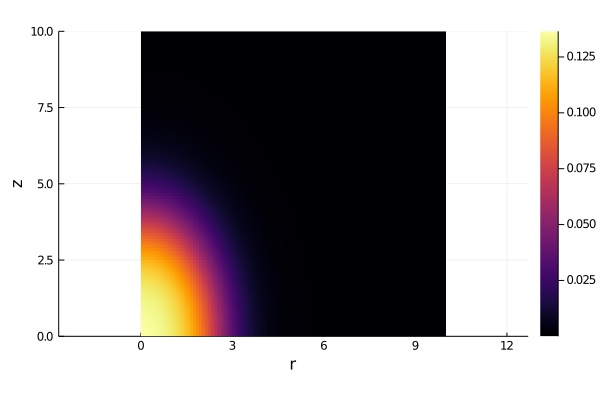

In [8]:
param = My.Parameters(β=-0.2)
test_initial_density(param, rs,  zs)

In [9]:
function calc_potential(param, rs, zs, ρ)
    ħc = param.ħc
    mc² = param.mc²
    
    t₀ = param.t₀
    t₃ = param.t₃
    α = param.α
    
    Vmat = zeros(Float64, length(rs), length(zs))
    @. Vmat += (3/4)*t₀*ρ + (α+2)/16*t₃*ρ^(α+1)
    
    @. Vmat *= 2mc²/ħc^2
    
    return Vmat
end


function calc_potential(param, rs, zs, ρ, μ, C)
    Nr = length(rs)
    Nz = length(zs)
    
    Δr = rs[2] - rs[1]
    Δz = zs[2] - zs[1]
    
    Vmat = calc_potential(param, rs, zs, ρ)
    
    ħc = param.ħc
    mc² = param.mc²
    #λ = param.λ
    q20 = calc_q20(param, rs, zs, ρ)
    for iz in 1:Nz,  ir in 1:Nr
        r = rs[ir]
        z = zs[iz]
        Vmat[ir, iz] += C*(q20 - μ)*sqrt(5/16π)*(2z^2 - r^2)*2mc²/ħc^2
    end
    
    return Vmat
end



function test_calc_potential(param, rs, zs)
    ρ = initial_density(param, rs, zs)
    Vmat = calc_potential(param, rs, zs, ρ)
    
    Hmat = make_Hamiltonian(rs, zs, Vmat, 0, 1)
    vals, vecs = eigs(Hmat, nev=20, which=:SM)
    println(real(vals[real.(vals) .< 0]) .* param.ħc^2/2param.mc²)
    #println(vals)
    
    heatmap(rs, zs, Vmat; xlabel="r", ylabel="z", ratio=:equal)
end


function test_calc_potential(param, rs, zs, μ, C)
    ρ = initial_density(param, rs, zs)
    Vmat = calc_potential(param, rs, zs, ρ, μ, C)
    
    #=
    Hmat = make_Hamiltonian(rs, zs, Vmat, 0, 1)
    vals, vecs = eigs(Hmat, nev=20, which=:SM)
    println(real(vals[real.(vals) .< 0]) .* param.ħc^2/2param.mc²)
    =#
    #println(vals)
    
    heatmap(rs, zs, Vmat; xlabel="r", ylabel="z", ratio=:equal)
end

test_calc_potential (generic function with 2 methods)

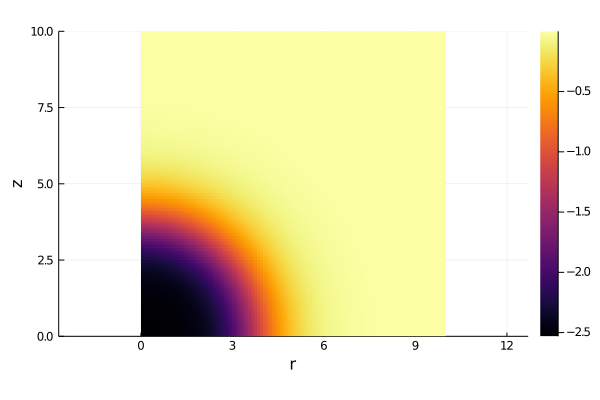

In [10]:
param = My.Parameters(Z = 8)
test_calc_potential(param, rs, zs, 0, 0)

In [11]:
function calc_norm(rs, zs, ψ)
    Nr = length(rs)
    Nz = length(zs)
    
    N = Nr*Nz
    @assert N==length(ψ)
    
    Δr = rs[2] - rs[1]
    Δz = zs[2] - zs[1]
    
    #=
    norm = 0.0
    for i in 1:N
        ir = i%Nr + 1
        norm += rs[ir]*abs(conj(ψ[i])*ψ[i])
    end
    =#
    
    norm = 0.0
    for iz in 1:Nz,  ir in 1:Nr
        i = (iz - 1)*Nr + ir
        norm += rs[ir]*abs(conj(ψ[i])*ψ[i])
    end
        
    return sqrt(norm*2*Δr*Δz)
end

function calc_states(param, rs, zs, ρ; Emax=0, Λmax=5, nev=20)
    ħc = param.ħc
    mc² = param.mc²
    
    Δr = rs[2] - rs[1]
    Δz = zs[2] - zs[1]
    
    states = My.SingleParticleState[]
    for Λ in 0:Λmax, Π in 1: -2: -1
        qnums = My.QuantumNumbers(Λ=Λ, Π=Π)
        Vmat = calc_potential(param, rs, zs, ρ)
        
        Hmat = make_Hamiltonian(rs, zs, Vmat, Λ, Π)
        vals, vecs = eigs(Hmat, nev=nev, which=:SM)
        
        # normalization 
        @. vals *= ħc^2/2mc²
        
        for i in 1:length(vals)
            if real(vals[i]) > 0
                continue
            end
            vecs[:, i] /= calc_norm(rs, zs, vecs[:, i])
            #@show calc_norm(rs, zs, vecs[:, i])
            push!(states, My.SingleParticleState(E=real(vals[i]), qnums=qnums, ψ=vecs[:, i]))
        end
    end
    
    return sort(states, by=state->state.E)
end


function calc_states(param, rs, zs, ρ, μ, C; Emax=0, Λmax=5, nev=20)
    ħc = param.ħc
    mc² = param.mc²
    
    Δr = rs[2] - rs[1]
    Δz = zs[2] - zs[1]
    
    states = My.SingleParticleState[]
    for Λ in 0:Λmax, Π in 1: -2: -1
        qnums = My.QuantumNumbers(Λ=Λ, Π=Π)
        Vmat = calc_potential(param, rs, zs, ρ, μ, C)
        
        Hmat = make_Hamiltonian(rs, zs, Vmat, Λ, Π)
        vals, vecs = eigs(Hmat, nev=nev, which=:SM)
        
        # normalization 
        @. vals *= ħc^2/2mc²
        
        for i in 1:length(vals)
            if real(vals[i]) > 0
                continue
            end
            vecs[:, i] /= calc_norm(rs, zs, vecs[:, i])
            #@show calc_norm(rs, zs, vecs[:, i])
            push!(states, My.SingleParticleState(E=real(vals[i]), qnums=qnums, ψ=vecs[:, i]))
        end
    end
    
    return sort(states, by=state->state.E)
end




function show_states(states)
    for i in 1:length(states)
        println("i = $i: ")
        @show states[i].E states[i].qnums
        println("")
    end
end

function test_calc_states(param, rs, zs)
    ρ = initial_density(param, rs, zs)
    @time states = calc_states(param, rs, zs, ρ)
    
    show_states(states)
end

test_calc_states (generic function with 1 method)

In [12]:
test_calc_states(param, rs, zs)

  5.629009 seconds (502.82 k allocations: 1005.410 MiB, 1.73% gc time)
i = 1: 
(states[i]).E = -37.545298092393224
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)

i = 2: 
(states[i]).E = -25.13609465878475
(states[i]).qnums = Main.My.QuantumNumbers(0, -1, 1)

i = 3: 
(states[i]).E = -25.13122604025134
(states[i]).qnums = Main.My.QuantumNumbers(1, -1, 1)

i = 4: 
(states[i]).E = -11.877069126677428
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)

i = 5: 
(states[i]).E = -11.864632239469621
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)

i = 6: 
(states[i]).E = -11.859064725029185
(states[i]).qnums = Main.My.QuantumNumbers(2, 1, 1)

i = 7: 
(states[i]).E = -10.542909725285027
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)

i = 8: 
(states[i]).E = -0.41560372112911725
(states[i]).qnums = Main.My.QuantumNumbers(0, -1, 1)

i = 9: 
(states[i]).E = -0.3571281145973944
(states[i]).qnums = Main.My.QuantumNumbers(1, -1, 1)



In [13]:
function calc_occ(param, states)
    A = param.A
    nstates = length(states)
    occ = zeros(Float64, nstates)
    n = 0
    for i in 1:nstates
        Λ = states[i].qnums.Λ
        Δn = 4
        if Λ > 0
            Δn *= 2
        end
        
        if n + Δn ≤ A
            occ[i] = 1
            n += Δn
        elseif n < A
            occ[i] = (A - n)/Δn
        end
    end
    @assert n == A
    
    return occ
end

function show_states(states, occ)
    for i in 1:length(states)
        println("i = $i: ")
        @show states[i].E  states[i].qnums  occ[i]
        println("")
    end
end

function test_calc_occ(param, rs, zs)
    ρ = initial_density(param, rs, zs)
    @time states = calc_states(param, rs, zs, ρ)
    occ = calc_occ(param, states)
    
    show_states(states, occ)
end








test_calc_occ (generic function with 1 method)

In [14]:
test_calc_occ(param, rs, zs)

  5.508127 seconds (16.18 k allocations: 986.770 MiB, 1.53% gc time)
i = 1: 
(states[i]).E = -37.545298092393146
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 1.0

i = 2: 
(states[i]).E = -25.13609465878403
(states[i]).qnums = Main.My.QuantumNumbers(0, -1, 1)
occ[i] = 1.0

i = 3: 
(states[i]).E = -25.131226040251278
(states[i]).qnums = Main.My.QuantumNumbers(1, -1, 1)
occ[i] = 1.0

i = 4: 
(states[i]).E = -11.87706912667744
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 0.0

i = 5: 
(states[i]).E = -11.864632239469646
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)
occ[i] = 0.0

i = 6: 
(states[i]).E = -11.859064725029134
(states[i]).qnums = Main.My.QuantumNumbers(2, 1, 1)
occ[i] = 0.0

i = 7: 
(states[i]).E = -10.542909725284993
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 0.0

i = 8: 
(states[i]).E = -0.415603721129129
(states[i]).qnums = Main.My.QuantumNumbers(0, -1, 1)
occ[i] = 0.0

i = 9: 
(states[i]).E = -0.3571281145973846
(states

In [15]:
function calc_density(rs, zs, states, occ)
    Nr = length(rs)
    Nz = length(zs)
    N = Nr*Nz
    
    ar = rs[2] - rs[1]
    az = zs[2] - zs[1]
    
    ρ = zeros(Float64, Nr, Nz)
    τ = zeros(Float64, Nr, Nz)
    
    for istate in 1:length(states)
        Λ = states[istate].qnums.Λ
        Π = states[istate].qnums.Π
        ψ = states[istate].ψ
        
        degeneracy = 4(1 + (Λ>0))
        
        #=
        norm = 0.0
        for iz in 1:Nz,  ir in 1:Nr
            i = (iz - 1)*Nr + ir
            norm += rs[ir]*abs(conj(ψ[i])*ψ[i])
        end
        norm *= 2*ar*az
        @show norm
        
        norm = 0.0
        for i in 1:N
            ir = i%Nr + 1
            norm += rs[ir]*abs(conj(ψ[i])*ψ[i])
        end
        norm *= 2*ar*az
        @show norm
        =#
        
        # number density
        for iz in 1:Nz,  ir in 1:Nr
            i = (iz - 1)*Nr + ir
            ρ[ir, iz] += occ[istate] * degeneracy/2π * abs(conj(ψ[i])*ψ[i]) 
            
            drψ = 0.0 # derivative of ψ with respect to r
            dzψ = 0.0
            for dr in -1:1
                jr = ir + dr
                if jr > Nr || jr < 1
                    continue
                end
                
                for dz in -1:1
                    jz = iz + dz
                    if jz > Nz || jz < 1
                        continue
                    end
                    
                    j = (jz - 1)*Nr + jr
                    
                    if dz == 0
                        cij_r = calc_cij(ir, jr, ar, Nr, 1)
                        drψ += cij_r * ψ[j]
                    end
                    
                    if dr == 0
                        cij_z = calc_cij(iz, jz, az, Nz, Π*(2*iseven(Λ) - 1))
                        dzψ += cij_z * ψ[j]
                    end
                end
            end
            
            temp = abs(conj(drψ)*drψ) + abs(conj(dzψ)*dzψ)
            temp += (Λ/rs[ir])^2 * abs(conj(ψ[i])*ψ[i])
            τ[ir, iz] += occ[istate] * degeneracy/2π * temp
        end
        
        # kinetic density
        #=
        for iz in 1:Nz,  ir in 1:Nr
            i = (iz - 1)*Nr + ir
            
            drψ = 0.0 # derivative of ψ with respect to r
            for dr in -1:1
                jr = ir + dr
                jz = iz
                if jr > Nr || jr < 1
                    continue
                end
                j = (jz - 1)*Nr + jr
                cij_r = calc_cij(ir, jr, ar, Nr, 1)
                drψ += cij_r*ψ[j]
            end
            
            dzψ = 0.0 # derivative of ψ with respect to z
            for dz in -1:1
                jr = ir
                jz = iz + dz
                if jz > Nz || jz < 1
                    continue
                end
                j = (jz - 1)*Nr + jr
                cij_z = calc_cij(iz, jz, az, Nz, Π)
                dzψ += cij_z*ψ[j]
            end
            
            temp = abs(conj(drψ)*drψ)
            temp += abs(conj(dzψ)*dzψ)
            temp += (Λ/rs[ir])^2 * abs(conj(ψ[i])*ψ[i])
            τ[ir, iz] += occ[istate] * degeneracy/2π * temp
        end
        =#
        
    end
    
    #=
    sum = 0.0
    for iz in 1:Nz,  ir in 1:Nr
        sum += rs[ir]*ρ[ir, iz]
    end
    sum *= 4π*ar*az
    @show sum
    =#
    
    return ρ, τ
end

function test_calc_density(param, rs, zs)
    ρ = initial_density(param, rs, zs)
    @time states = calc_states(param, rs, zs, ρ)
    occ = calc_occ(param, states)
    
    @time ρ, τ = calc_density(rs, zs, states, occ)
    
    Nr = length(rs)
    Nz = length(zs)
    ar = rs[2] - rs[1]
    az = zs[2] - zs[1]
    sum = 0.0
    for iz in 1:Nz,  ir in 1:Nr
        sum += rs[ir]*ρ[ir, iz]
    end
    sum *= 4π*ar*az
    @show sum
    
    p = heatmap(rs, zs, ρ; xlabel="r", ylabel="z", ratio=:equal)
    display(p)
    
    p = heatmap(rs, zs, τ; xlabel="r", ylabel="z", ratio=:equal)
    display(p)
end

test_calc_density (generic function with 1 method)

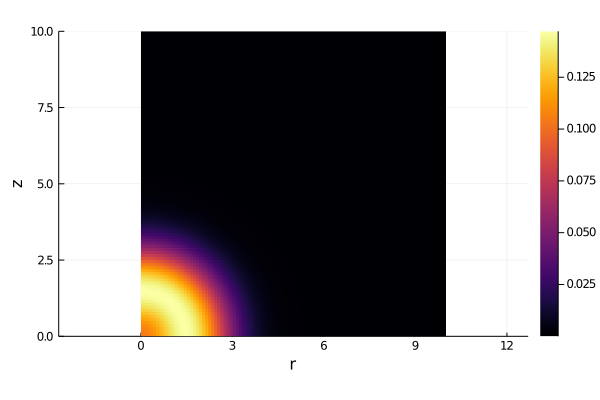

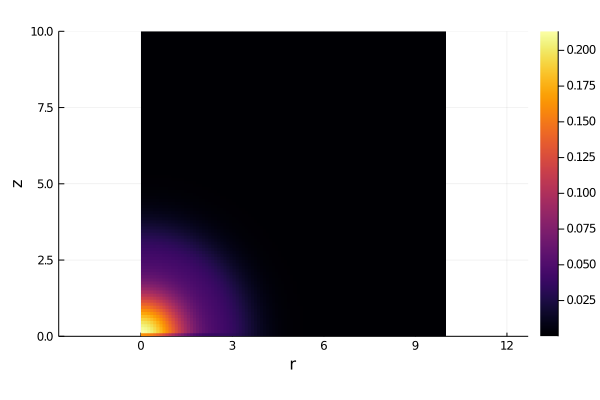

  5.361113 seconds (16.20 k allocations: 987.381 MiB, 1.61% gc time)
  0.037985 seconds (540.11 k allocations: 16.639 MiB, 13.62% gc time)
sum = 16.000000000000036


In [16]:
test_calc_density(param, rs, zs)

In [17]:
function calc_total_energy(param, rs, zs, ρ, τ)
    mc² = param.mc²
    ħc = param.ħc
    
    t₀ = param.t₀
    t₃ = param.t₃
    α = param.α
    
    Nr = length(rs)
    Nz = length(zs)
    
    Δr = rs[2] - rs[1]
    Δz = zs[2] - zs[1]
    
    ε = zeros(Float64, Nr, Nz)
    @. ε += ħc^2/2mc²*τ
    @. ε += (3/8)*t₀*ρ^2 + (t₃/16)*ρ^(α+2)
    
    E = 0.0
    for iz in 1:Nz,  ir in 1:Nr
        E += rs[ir]*ε[ir, iz]
    end
    E *= 4π*Δr*Δz
    
    #=
    for iz in 1:Nz,  ir in 1:Nr
        ε[ir, iz] *= 4π*rs[ir]
    end
    E = trapezoidal_rule(rs, zs, ε)
    =#
    
    return E
end

function calc_total_energy_from_functional(param, rs, zs, states, occ, ρ, τ)
    mc² = param.mc²
    ħc = param.ħc
    
    t₃ = param.t₃
    α = param.α
    
    Nr = length(rs)
    Nz = length(zs)
    
    Δr = rs[2] - rs[1]
    Δz = zs[2] - zs[1]
    
    ε = zeros(Float64, Nr, Nz) # energy density
    @. ε += ħc^2/4mc² * τ
    @. ε += -α/32 * t₃ * ρ^(α+2)
    
    E = 0.0
    for iz in 1:Nz,  ir in 1:Nr
        E += rs[ir]*ε[ir, iz]
    end
    E *= 4π*Δr*Δz
    
    for i in 1:length(states)
        Λ = states[i].qnums.Λ
        degeneracy = 4(1 + (Λ>0))
        E += occ[i] * degeneracy * states[i].E/2
    end
    
    return E
end


function calc_rmsr(param, rs, zs, ρ)
    Nr = length(rs)
    Nz = length(zs)
    
    Δr = rs[2] - rs[1]
    Δz = zs[2] - zs[1]
    
    rmsr = 0.0
    for iz in 1:Nz,  ir in 1:Nr
        rmsr += rs[ir]*(rs[ir]^2 + zs[iz]^2)*ρ[ir, iz]
    end
    rmsr *= 4π*Δr*Δz/param.A
    rmsr = sqrt(rmsr)
    
    return rmsr
end



function DFT_calc(param, rs, zs; iter_max=20, rtol=1e-5, Λmax=5)
    A = param.A
    Es = Float64[]
    
    ρ = initial_density(param, rs, zs)
    states = calc_states(param, rs, zs, ρ)
    occ = calc_occ(param, states)
    ρ, τ = calc_density(rs, zs, states, occ)
    push!(Es, calc_total_energy(param, rs, zs, ρ, τ))
    
    converge = false
    for iter in 1:iter_max
        states = calc_states(param, rs, zs, ρ)
        occ = calc_occ(param, states)
        ρ, τ = calc_density(rs, zs, states, occ)
        push!(Es, calc_total_energy(param, rs, zs, ρ, τ))
        
        if iter ≥ 2 && abs((Es[end] - Es[end-1])/Es[end]) < rtol
            println("iteration converged at iter = $iter")
            converge = true
            break
        end
    end
    
    show_states(states, occ)
    
    p = heatmap(rs, zs, ρ; xlabel="r [fm]", ylabel="z [fm]", 
        ratio=:equal, title="Z = N = $(param.Z)")
    display(p)
    
    p = plot(Es; xlabel="iter", ylabel="total energy")
    display(p)
    
    ρ, τ = calc_density(rs, zs, states, occ)
    Etot = calc_total_energy(param, rs, zs, ρ, τ)
    Etot_functional = calc_total_energy_from_functional(param, rs, zs, states, occ, ρ, τ)
    q20 = calc_q20(param, rs, zs, ρ)
    rmsr = calc_rmsr(param, rs, zs, ρ)
    @show Etot  Etot_functional  rmsr q20
    
    if !converge
        error("no convergence")
    end
    
    return
end

DFT_calc (generic function with 1 method)

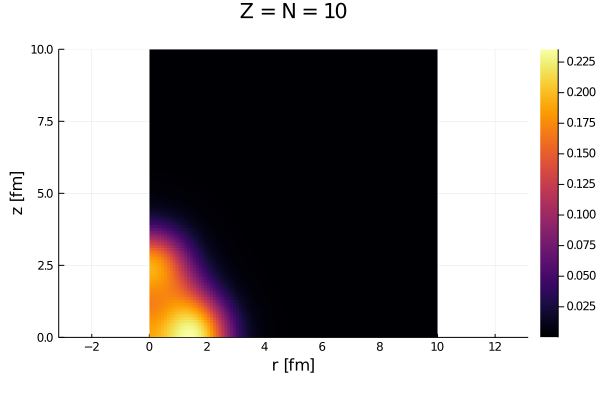

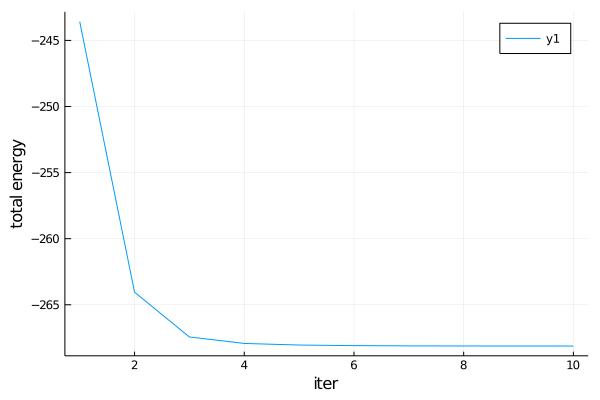

iteration converged at iter = 9
i = 1: 
(states[i]).E = -38.644478217397385
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 1.0

i = 2: 
(states[i]).E = -27.941009749648906
(states[i]).qnums = Main.My.QuantumNumbers(1, -1, 1)
occ[i] = 1.0

i = 3: 
(states[i]).E = -21.879268096319606
(states[i]).qnums = Main.My.QuantumNumbers(0, -1, 1)
occ[i] = 1.0

i = 4: 
(states[i]).E = -15.542006740714386
(states[i]).qnums = Main.My.QuantumNumbers(2, 1, 1)
occ[i] = 0.5

i = 5: 
(states[i]).E = -13.994366182971849
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 1.0

i = 6: 
(states[i]).E = -7.575647834936084
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)
occ[i] = 0.0

i = 7: 
(states[i]).E = -3.5481992256350265
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 0.0

i = 8: 
(states[i]).E = -2.126658615315859
(states[i]).qnums = Main.My.QuantumNumbers(3, -1, 1)
occ[i] = 0.0

i = 9: 
(states[i]).E = -0.3237342015608166
(states[i]).qnums = Main.My.QuantumNumbers(

In [18]:
Z = 10
a = 0.1
N = 100
param = My.Parameters(Z=Z, β=-0.2)
rs, zs = make_grids(a, N)
@time DFT_calc(param, rs, zs; iter_max=20)

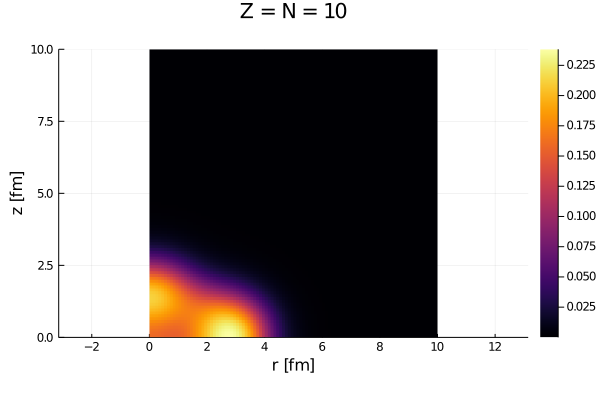

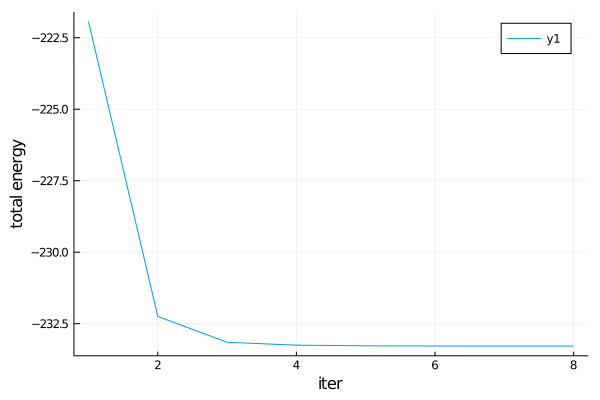

iteration converged at iter = 7
i = 1: 
(states[i]).E = -37.03859832771755
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 1.0

i = 2: 
(states[i]).E = -26.907448436924707
(states[i]).qnums = Main.My.QuantumNumbers(0, -1, 1)
occ[i] = 1.0

i = 3: 
(states[i]).E = -21.06212679293436
(states[i]).qnums = Main.My.QuantumNumbers(1, -1, 1)
occ[i] = 1.0

i = 4: 
(states[i]).E = -16.202642419596017
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 1.0

i = 5: 
(states[i]).E = -7.687385374649013
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)
occ[i] = 0.0

i = 6: 
(states[i]).E = -3.9465667291745636
(states[i]).qnums = Main.My.QuantumNumbers(0, -1, 1)
occ[i] = 0.0

i = 7: 
(states[i]).E = -3.67634845154258
(states[i]).qnums = Main.My.QuantumNumbers(2, 1, 1)
occ[i] = 0.0

i = 8: 
(states[i]).E = -2.116701360773649
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 0.0

Etot = -233.28084045309473
Etot_functional = -232.90585418058717
rmsr = 2.681664153765024
q

In [19]:
Z = 10
a = 0.1
N = 100
param = My.Parameters(Z=Z, β=+0.2)
rs, zs = make_grids(a, N)
@time DFT_calc(param, rs, zs; iter_max=20)

In [540]:
#=
function calc_total_energy(param, rs, zs, ρ, τ, μ, C)
    mc² = param.mc²
    ħc = param.ħc
    
    t₀ = param.t₀
    t₃ = param.t₃
    α = param.α
    
    Nr = length(rs)
    Nz = length(zs)
    
    Δr = rs[2] - rs[1]
    Δz = zs[2] - zs[1]
    
    E = calc_total_energy(param, rs, zs, ρ, τ)
    
    
    q20 = calc_q20(param, rs, zs, ρ)
    #@show (λ/2)*(q20 - q)^2
    E += (C/2)*(q20 - μ)^2
    
    
    return E
end


function DFT_calc(param, rs, zs, μ₀
        ; iter_max=20, 
        rtol=1e-5, 
        Λmax=5, 
        show=true, 
        epscst=0.5)
    
    A = param.A
    ρ = initial_density(param, rs, zs, μ₀)
    states = calc_states(param, rs, zs, ρ)
    occ = calc_occ(param, states)
    ρ, τ = calc_density(rs, zs, states, occ)
    
    q20 = calc_q20(param, rs, zs, ρ)
    C = 2/(q20 - μ₀)^2 * 0.5
    μ = μ₀ 
    @show C  q20
    
    
    Es = Float64[]
    
    converge = false
    for iter in 1:iter_max
        states = calc_states(param, rs, zs, ρ, μ, C)
        occ = calc_occ(param, states)
        ρ, τ = calc_density(rs, zs, states, occ)
        @. ρ = (ρ + ρ_new)/2
        @. τ = (τ + τ_new)/2
        push!(Es, calc_total_energy(param, rs, zs, ρ, τ))
        
        q20 = calc_q20(param, rs, zs, ρ)
        μ = μ - epscst*(q20 - μ₀)
        
        
        if iter ≥ 2 && abs((Es[end] - Es[end-1])/Es[end]) < rtol 
            println("iteration converged at iter = $iter")
            converge = true
            break
        end
    end
    
    if show
        #show_states(states, occ)

        p = heatmap(rs, zs, ρ; xlabel="r [fm]", ylabel="z [fm]", 
            ratio=:equal, title="Z = N = $(param.Z)")
        display(p)

        p = plot(Es; xlabel="iter", ylabel="total energy")
        display(p)
        
    end
    
    Etot = calc_total_energy(param, rs, zs, ρ, τ)
    Etot_functional = calc_total_energy_from_functional(param, rs, zs, states, occ, ρ, τ)
    q20 = calc_q20(param, rs, zs, ρ)
    rmsr = calc_rmsr(param, rs, zs, ρ)
    if show 
        @show Etot  Etot_functional  rmsr q20
    end
    
    return Etot, q20
end
=#

DFT_calc (generic function with 2 methods)

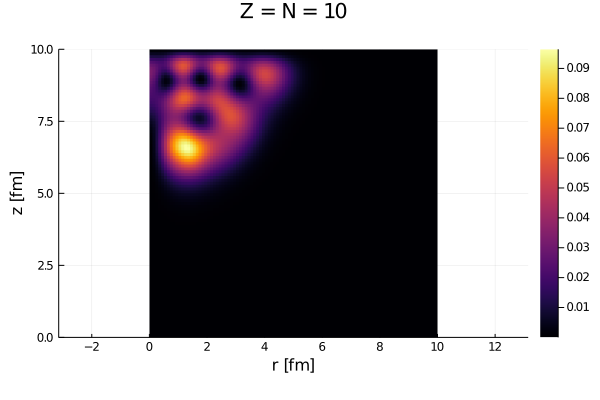

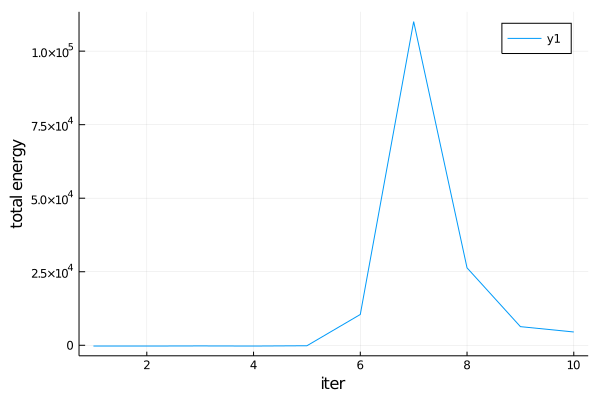

C = 0.06533164627970765
q20 = -13.912354495402559
Etot = 4518.82393633784
Etot_functional = 246.95308849454705
rmsr = 14.516973328296011
q20 = -969.3542803329707
 67.179986 seconds (40.12 M allocations: 11.921 GiB, 1.62% gc time)


(4518.82393633784, -969.3542803329707)

In [541]:
#=
Z = 10
a = 0.1
N = 100
μ = -10
param = My.Parameters(Z=Z)
rs, zs = make_grids(a, N)

@time Etot, q20 = DFT_calc(param, rs, zs, μ; iter_max=10, show=true, epscst=0.8)
=#